In [10]:
# !pip install Bio
# # !pip install dasK

# !pip install numpy
# !pip install pandas

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# import swifter
import gc
import timeit
# from numba import jit, cuda
# import dask.dataframe as dd
# from dask.multiprocessing import get
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from scipy import sparse
import seaborn as sn
from joblib import dump, load
import multiprocessing as mp
# from pandarallel import pandarallel

%matplotlib inline

In [29]:
# pandarallel.initialize()

In [30]:
labels = []
def importLabels():
    # with open('./Data/labels.txt', 'r') as filehandle:
    with open('./Data/shortlabels.txt', 'r') as filehandle:
        for line in filehandle:
            # remove linebreak, if exists, which is the last character of the string
            if(line[-1] == "\n"):
                currentPlace = line[:-1]
            else:
                currentPlace = line[:]
            # add item to the list
            labels.append(currentPlace)
importLabels()

In [31]:
print(len(labels))

1000


In [32]:
identifiers = [] # list
sequences = [] # list

# with open('/content/drive/MyDrive/S2/TM/TM DataSet/Data/sequences.fasta') as fasta_file:  # Will close handle cleanly
with open('./Data/short.fasta') as fasta_file:  # Will close handle cleanly

    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        sequences.append(str(seq_record.seq))
print(len(sequences))

1000


# *varKmers* : converts sequence of DNA into variable length k-mers between lower and upper bounds (included)

In [33]:


def varKmers(sequence, lower, upper):
    # threadsperblock = 32
    # blockspergrid = (len(sequence) + (threadsperblock - 1)) // threadsperblock
    res = []
    for i in range(lower, upper+1): 
        res = res + genKmers(sequence, i)
#         res = res + worder(sequence, i)

    return res
def genKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [34]:
# def worder(prot_1, 3)

In [73]:
dfKmers = DataFrame(sequences,columns=['sequences'])
# ddata = dd.from_pandas(dfKmers, npartitions=8)
min = 5
max = 8

def createKmers(min, max):
    dfKmers['kmers'] = dfKmers['sequences'].apply(lambda x: varKmers(x,min,max))    

def concatKmers():
    dfKmers['concatenated Kmers'] = dfKmers['kmers'].apply(lambda x: ' '.join(map(str, x)))

t_pds = timeit.Timer(lambda: createKmers(min, max))
print("Time took to create k-mers", t_pds.timeit(number=1))

t_pds = timeit.Timer(lambda: concatKmers())
print("Time took to create concatenated k-mers sequences: ",  t_pds.timeit(number=1))

dfKmers.drop('kmers', inplace=True, axis=1)
dfKmers.drop('sequences', inplace=True, axis=1)
dfKmers.head()

Time took to create k-mers 9.038289099999929
Time took to create concatenated k-mers sequences:  3.5866949999999633


,concatenated Kmers
0,ggagc gagcg agcga gcgaa cgaaa gaaaa aaaag aaag...
1,tgacg gacgc acgcg cgcgg gcggc cggct ggcta gcta...
2,acttt ctttc tttcg ttcgc tcgca cgcac gcaca caca...
3,tcccc cccca cccaa ccaag caagg aaggt aggta ggta...
4,ctcct tcctc cctca ctcaa tcaag caagc aagcg agcg...


## Plot to show data distriution over the two classes 


In [74]:
# DataFrame(labels).value_counts().sort_index().plot.bar()


In [75]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

In [76]:
cv = CountVectorizer(ngram_range=(4,4))
Xcv = cv.fit_transform(list(dfKmers['concatenated Kmers']))
# selector = SelectPercentile(score_func=chi2, percentile=10)
# # X = selector.fit_transform(cv.fit_transform(list(dfKmers['concatenated Kmers'])), labels)
# X = selector.fit_transform(Xcv, labels)


In [77]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The ideal n-gram size is to be determined later
# cv = CountVectorizer(ngram_range=(4,4))
# Xcv = cv.fit_transform(list(dfKmers['concatenated Kmers']))
# selector = SelectPercentile(score_func=chi2, percentile=1)
# X = selector.fit_transform(Xcv, labels)

# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                             labels, 
#                                             test_size = 0.20, 
#                                             random_state=42)

# clf = GaussianNB()
# clf.fit(X_train.toarray(), y_train)
# y_pred = clf.predict(X_test.toarray())
# accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)


In [78]:
# print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

In [79]:



# X_train, X_test, y_train, y_test = train_test_split(X, 
#                                                     labels, 
#                                                     test_size = 0.20, 
#                                                     random_state=42)
labs = ['percentile', 'accuracy', 'precision', 'recall', 'f1']
Data = []

def findBestPercentile():
    for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:#, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]:
        selector = SelectPercentile(score_func=chi2, percentile=i)
        X = selector.fit_transform(Xcv, labels)
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        labels, 
                                                        test_size = 0.20, 
                                                        random_state=42)

        clf = GaussianNB()
        clf.fit(X_train.toarray(), y_train)
        y_pred = clf.predict(X_test.toarray())
        accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
        Data.append({'percentile': i,'accuracy': accuracy,'precision': precision, 'recall':recall, 'f1':f1,'X_train.shape': X_train.shape, 'X_test.shape': X_test.shape})
#         print("Perc : "+ str(i)+ "  &  X_train.shape :",  X_train.shape)
#         print("  & X_test.shape :", X_test.shape)
#         print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

    display(pd.DataFrame(Data))

In [80]:
findBestPercentile()

,percentile,accuracy,precision,recall,f1,X_train.shape,X_test.shape
0,0.1,1.0,1.0,1.0,1.0,"(800, 5195)","(200, 5195)"
1,0.2,1.0,1.0,1.0,1.0,"(800, 10390)","(200, 10390)"
2,0.3,1.0,1.0,1.0,1.0,"(800, 15585)","(200, 15585)"
3,0.4,1.0,1.0,1.0,1.0,"(800, 20780)","(200, 20780)"
4,0.5,1.0,1.0,1.0,1.0,"(800, 25975)","(200, 25975)"
5,0.6,1.0,1.0,1.0,1.0,"(800, 31170)","(200, 31170)"
6,0.7,1.0,1.0,1.0,1.0,"(800, 36365)","(200, 36365)"
7,0.8,1.0,1.0,1.0,1.0,"(800, 41560)","(200, 41560)"
8,0.9,1.0,1.0,1.0,1.0,"(800, 46755)","(200, 46755)"
9,1.0,1.0,1.0,1.0,1.0,"(800, 51950)","(200, 51950)"


In [43]:

# clf = load('./saved/clf.joblib') 


In [44]:


# print("Confusion matrix\n")
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted'))



accuracy = 0.660 
precision = 0.660 
recall = 0.660 
f1 = 0.658


array([[75, 29],
       [39, 57]], dtype=int64)

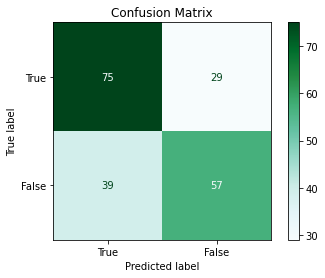

In [45]:
class_names = ['True', 'False']
disp = plot_confusion_matrix(clf, X_test.toarray(), y_test,
                             display_labels=class_names,
                             cmap=plt.cm.BuGn)
disp.ax_.set_title('Confusion Matrix')
disp.confusion_matrix



In [46]:
# sn.heatmap(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')), annot=True,cmap="OrRd")
# dump(clf, './saved/clf.joblib') 
# clf = load('./saved/clf.joblib') 